In [1]:
## TA NOTE: MySQL within Python does not work for me, I placed the code that I think is correct.

# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [23]:
# Import your libraries:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import seaborn as sns
from scipy import stats

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [ ]:
#Create a connection with create_engine to MySQL Workbench:

import mysql.connector
import getpass
saved_password = getpass.getpass()

cnx = mysql.connector.connect(user = 'root',password = saved_password, host ='localhost', 
                              database = 'lab-unsupervised-learning')
cnx.is_connected()
cursor = cnx.cursor()

query = ("SELECT * FROM wholesale_customers_data;")

In [4]:
customers_df = pd.read_csv('C:/Users/FiercePC/Desktop/Ironhack/Labs/Labs/lab-unsupervised-learning/wholesale_customers_data.csv')

In [5]:
customers_df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
101,2,3,1420,10810,16267,1593,6766,1838
107,2,3,8797,10646,14886,2471,8969,1438
212,1,1,7291,1012,2062,1291,240,1775
337,1,2,9351,1347,2611,8170,442,868
74,2,3,8190,6343,9794,1285,1901,1780


In [6]:
customers_df.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [7]:
customers_df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [8]:
customers_df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


<AxesSubplot:>

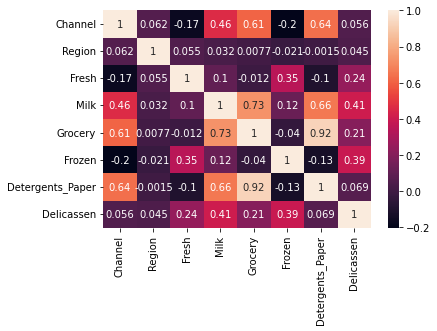

In [9]:
sns.heatmap(customers_df.corr(), annot = True)

In [10]:
# Categorical Column
customers_df['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

In [11]:
# Categorical Column
customers_df['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [12]:
# 2 Cat. Columns - Channel (Online or InStore) & Region
# Remaining Columns - Annual spending on different products
# One columns with high correlation that might need to be dropped: Detergents_Paper

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [14]:
customers_df = customers_df.drop('Detergents_Paper', axis = 1)

In [26]:
# Removing outliers using z-score
z_scores = np.abs(stats.zscore(customers_df))
threshold = 3
customers_df_z = customers_df[(z_scores < threshold).all(axis=1)]

customers_df_z.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Delicassen
0,2,3,12669,9656,7561,214,1338
1,2,3,7057,9810,9568,1762,1776
2,2,3,6353,8808,7684,2405,7844
3,1,3,13265,1196,4221,6404,1788
4,2,3,22615,5410,7198,3915,5185


In [27]:
len(customers_df_z)

416

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [29]:
# Your import here:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customers_scaler = scaler.fit_transform(customers_df_z[['Fresh','Milk','Frozen','Delicassen','Grocery']])

In [30]:
customers_scaled = pd.DataFrame(customers_scaler, columns = ['Fresh','Milk','Frozen','Delicassen','Grocery'])

In [31]:
customers_scaled

,Fresh,Milk,Frozen,Delicassen,Grocery
0,0.201488,0.985150,-0.805750,0.065492,0.093115
1,-0.371949,1.017527,-0.274447,0.418021,0.393580
2,-0.443884,0.806868,-0.053757,5.301918,0.111529
3,0.262388,-0.793473,1.318777,0.427679,-0.406911
4,1.217777,0.092475,0.464504,3.161793,0.038771
...,...,...,...,...,...
411,1.942033,1.488673,3.628987,0.762501,1.360547
412,2.915303,-0.744067,0.668720,0.876792,-0.924454
413,0.391749,2.211265,-0.729212,0.491263,3.488804
414,-0.041599,-0.628435,-0.522938,0.698917,-0.704682


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

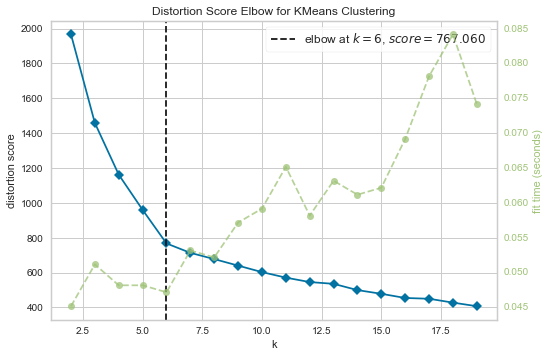

C:\Users\FiercePC\AppData\Local\Temp\ipykernel_14680\1086477146.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df_z['labels'] = kmeans.labels_


In [37]:
from sklearn import cluster
from yellowbrick.cluster import KElbowVisualizer

model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k = (2,20))
visualizer.fit(customers_scaled)
visualizer.poof()

kmeans = cluster.KMeans(n_clusters = 6)
kmeans = kmeans.fit(customers_scaled)

customers_scaled['labels'] = kmeans.labels_
customers_df_z['labels'] = kmeans.labels_

Count the values in `labels`.

In [39]:
customers_scaled['labels'].value_counts()

0    174
3     89
5     49
1     42
2     38
4     24
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [42]:
dbs = cluster.DBSCAN(eps = 0.5)
dbs = dbscan.fit(customers_scaled)

customers_scaled['labels_DBSCAN'] = dbscan.labels_
customers_df_z['labels_DBSCAN'] = dbscan.labels_

customers_scaled.head()

C:\Users\FiercePC\AppData\Local\Temp\ipykernel_14680\2465556507.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_df_z['labels_DBSCAN'] = dbscan.labels_


,Fresh,Milk,Frozen,Delicassen,Grocery,labels,labels_DBSCAN
0,0.201488,0.985150,-0.805750,0.065492,0.093115,3,-1
1,-0.371949,1.017527,-0.274447,0.418021,0.393580,3,-1
2,-0.443884,0.806868,-0.053757,5.301918,0.111529,2,-1
3,0.262388,-0.793473,1.318777,0.427679,-0.406911,1,-1
4,1.217777,0.092475,0.464504,3.161793,0.038771,2,-1


Count the values in `labels_DBSCAN`.

In [43]:
customers_scaled['labels_DBSCAN'].value_counts()

-1    269
 0    124
 1     11
 3      5
 4      4
 2      3
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# I dropped Detergents_Paper, maybe I was wrong? Oops

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

<AxesSubplot:xlabel='Grocery', ylabel='Fresh'>

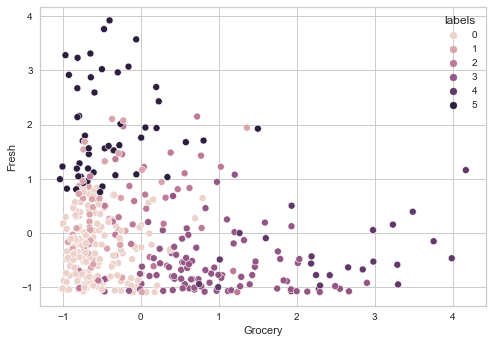

In [51]:
sns.scatterplot(x = 'Grocery', y = 'Fresh',
                hue = 'labels',
                data = customers_scaled)

<AxesSubplot:xlabel='Grocery', ylabel='Fresh'>

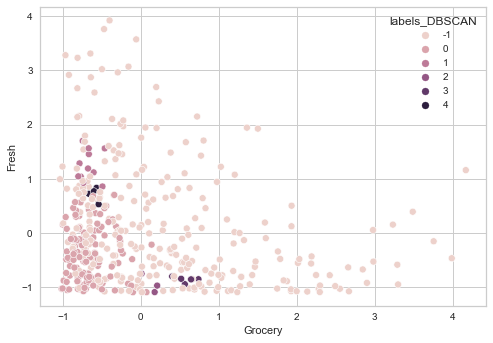

In [47]:
sns.scatterplot(x = 'Grocery', y = 'Fresh',
                hue = 'labels_DBSCAN',
                data = customers_scaled)

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

<AxesSubplot:xlabel='Frozen', ylabel='Delicassen'>

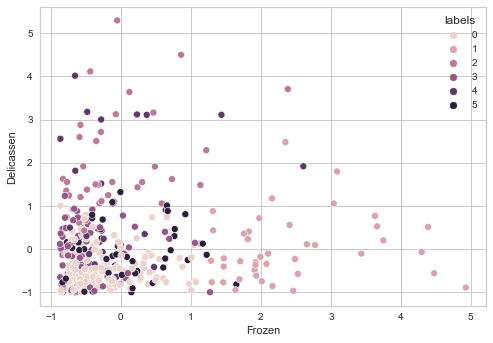

In [50]:
sns.scatterplot(x = 'Frozen', y = 'Delicassen',
                hue = 'labels',
                data = customers_scaled)

<AxesSubplot:xlabel='Frozen', ylabel='Delicassen'>

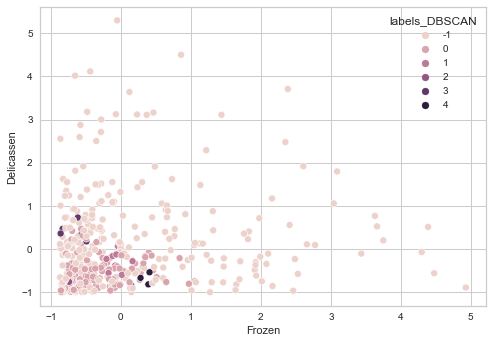

In [49]:
sns.scatterplot(x = 'Frozen', y = 'Delicassen',
                hue = 'labels_DBSCAN',
                data = customers_scaled)

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [52]:
customers_df_z.groupby(by = 'labels').agg('mean').mean()

Channel              1.405133
Region               2.534646
Fresh            12781.621113
Milk              6827.868062
Grocery           9123.865287
Frozen            3255.469063
Delicassen        1745.163519
labels_DBSCAN       -0.741165
dtype: float64

Which algorithm appears to perform better?

In [ ]:
# KMEANS, DBSCAN's mean is much lower

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here